Note: if you have downloaded the results folder from zenodo, you do not have to run this notebook.

# Overall performance of module detection methods

In [1]:
import sys
import os
sys.path.insert(0,os.path.abspath("../lib/"))

import json

from util import JSONExtendedEncoder

from modulecontainers import Modules

%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib.pyplot import *

import pandas as pd
import numpy as np

import multiprocessing as mp

from collections import OrderedDict

from itertools import product
from collections import defaultdict

import itertools
import shutil

conf_folder = "conf/"

import os

from modulescomparison import ModevalKnownmodules, ModevalCoverage

# Running a method on different parameter settings and datasets

In [6]:
# datasets to run
datasetnames = ["ecoli_colombos", "ecoli_dream5", "yeast_gpl2529", "yeast_dream5", "synth_ecoli_regulondb", "synth_yeast_macisaac", "human_tcga", "human_gtex", "human_seek_gpl5175", "ecoli_precise2"]

# paramexplo_blueprints.py stores for every method the parameters which will be varied using a grid-search approach.
%run ../conf/paramexplo_blueprints.py

# choose the method to evaluate
method_name = "baseline_permuted"
methodblueprint = blueprints[method_name]

Generate different parameter settings using a grid-search.

In [7]:
params_folder = "conf/paramexplo/" + method_name + "/"
if os.path.exists("../" + params_folder):
    shutil.rmtree("../" + params_folder)
os.makedirs("../" + params_folder)

methodsettings = []
method_locations = []
i = 0
for dynparam_combination in list(itertools.product(*[methodblueprint["dynparams"][param] for param in sorted(methodblueprint["dynparams"].keys())])):
    method = {"params":{}}
    method["params"] = methodblueprint["staticparams"].copy()
    method["params"].update(dict(zip(sorted(methodblueprint["dynparams"].keys()), dynparam_combination)))
    method["location"] = params_folder + str(i) + ".json"
    method["seed"] = 0

    methodsettings.append(method)

    json.dump(method, open("../" + method["location"], "w"), cls=JSONExtendedEncoder)

    method_locations.append(method["location"])

    i+=1

Now combine the different parameter settings and datasets. Then generate the different python commands to run every parameter setting and dataset in parallel.

In [8]:
settings_name = "paramexplo/{method_name}".format(method_name = method_name)
settings = []
i = -1
for datasetname, methodsetting in product(datasetnames, methodsettings):
    dataset_location = "conf/datasets/" + datasetname + ".json"
    dataset = json.load(open("../" + dataset_location))
    
    for regnet_name, regnet in dataset["knownmodules"].items():
        for knownmodules_name in regnet.keys():
            if os.path.exists("../" + regnet[knownmodules_name]):
                i += 1
                settings.append({
                    "dataset_location":dataset_location,
                    "dataset_name":datasetname,
                    "method_location":methodsetting["location"],
                    "regnet_name":regnet_name,
                    "knownmodules_name":knownmodules_name,
                    "output_folder":"results/" + methodblueprint["type"] + "/{settings_name}/{i}/".format(settings_name=settings_name, i=i),
                    "settingid":i
                    }
                )
json.dump(settings, open("../conf/settings/{settings_name}.json".format(settings_name=settings_name), "w"))

In [9]:
len(settings)

116

In [10]:
settings_dataset = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["dataset_location"]))["params"]) for setting in settings])
settings_method = pd.DataFrame([dict(settingid=setting["settingid"], **json.load(open("../" + setting["method_location"]))["params"]) for setting in settings])

In [11]:
commands = ""
for i, setting in enumerate(settings):
    #commands += "python scripts/moduledetection.py {method_location} {dataset_location} {output_folder} 0 test\n".format(**setting)
    commands += "python3 scripts/" + methodblueprint["type"] + "_baseline.py {method_location} {dataset_location} {regnet_name} {knownmodules_name} {output_folder}\n".format(**setting)

commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs("../" + os.path.dirname(commands_location), exist_ok=True)
with open("../" + commands_location, "w") as outfile:
    outfile.write(commands)
commands_location = "tmp/{settings_name}.txt".format(**locals())
os.makedirs(os.path.dirname("../tmp/" + commands_location), exist_ok=True)
with open("../tmp/" + commands_location, "w") as outfile:
    outfile.write(commands)
    
#script_location = generate_batchcode(commands_location, settings_name, len(settings), {"memory":"10G", "numcores":1}, "biclust_comp2")

# this command can be used on most linux computers to run the different parameter settings in parallel
print("parallel -a " + commands_location)

parallel -a tmp/paramexplo/baseline_permuted.txt


# Evaluating the method

## By comparing with known modules

Evaluate by comparing with known modules

In [92]:
# create pool of processors
if "pool" in locals().keys():
    pool.close()
pool = mp.Pool(mp.cpu_count()-1)

In [93]:
settings_filtered = [setting for setting in settings if not setting["dataset_name"].startswith("human")] # only evaluate non-human datasets
modeval = ModevalKnownmodules(settings_filtered, baseline = False)

In [10]:
modeval.run(pool)
modeval.save(settings_name)

In [95]:
modeval.load(settings_name)

In [96]:
scores

,aucodds,settingid,goldstandard,runningtime,baseline_name
0,0.079982,107,regcircuit,0.008777,permuted
1,0.047083,89,regcircuit,0.014445,permuted
2,0.048440,98,regcircuit,0.012152,permuted
3,0.113223,114,regcircuit,0.040973,permuted
4,0.088479,96,regcircuit,0.037224,permuted
5,0.038716,110,regcircuit,0.244364,permuted
6,0.050046,105,regcircuit,0.085500,permuted
7,0.021342,112,regcircuit,0.253031,permuted
8,0.028177,92,regcircuit,0.401433,permuted
9,0.014872,101,regcircuit,0.137695,permuted


In [97]:
scores = []
for setting in settings:
    score = modeval.scores.loc[
        (modeval.scores["settingid"] == setting["settingid"]) &
        (modeval.scores["knownmodules_name"] == setting["knownmodules_name"]) &
        (modeval.scores["regnet_name"] == setting["regnet_name"])
    ]
    
    scores.append(score)
scores = pd.concat(scores)
scores["baseline_name"] = "permuted"
baseline = scores.groupby(["baseline_name", "regnet_name", "knownmodules_name"]).mean()

In [98]:
baseline.to_csv("../results/modeval_knownmodules/baseline.tsv") 

## Using the coverage of regulators

In [9]:
from modulescomparison import ModevalCoverage

In [10]:
settings_filtered = [setting for setting in settings if setting["dataset_name"].startswith("human")] # only evaluate human datasets
modeval = ModevalCoverage(settings_filtered)

In [116]:
# built a pool of processors
if "pool" in locals().keys():
    pool.close()
pool = mp.Pool(mp.cpu_count()-1)

In [ ]:
modeval.run(pool)

Evaluating a total of 27 settings.


In [79]:
modeval.save(settings_name)

In [11]:
modeval.load(settings_name)

In [14]:
scores = modeval.scores
scores["baseline_name"] = "permuted"
baseline = scores.groupby(["baseline_name", "goldstandard"]).mean()

In [15]:
baseline

,,aucodds,settingid,runningtime
baseline_name,goldstandard,,,
permuted,regcircuit,0.026501,101.0,0.53842


In [17]:
baseline.to_csv("../results/modeval_coverage/baseline.csv") 

## Comparing with other methods

In [21]:
def score_method(scores):
    methodscores = []
    for ((datasetoi, goldstandardoi), scoresoi), ((datasetor, goldstandardor), scoresor) in product(scores.groupby(["datasetname", "goldstandard"]), scores.groupby(["datasetname", "goldstandard"])):
        if (datasetor.split("_")[0]=="synth" and datasetoi.split("_")[0]!="synth") or (datasetor.split("_")[0]!="synth" and datasetoi.split("_")[0]=="synth"):
            continue
                
        if (goldstandardoi.split("#")[-1] != goldstandardor.split("#")[-1]):
            if (datasetoi.startswith("human") != datasetor.startswith("human")):
                ""
            else:
                continue

        # find the most optimal method parameters in the reference dataset (test dataset)
        bestparams = scoresor[paramsoi].loc[scoresor["score"].idxmax()]
        
        try:
            rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]
        except:
            print(scoresoi)

        # now find these parameters in the dataset of interest (training dataset)
        rowids = scoresoi.index[np.where(np.all([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()], 0))[0]]
            
        if len(rowids) == 0:
            print("parameters could not be matched!!", datasetoi, datasetor)
            print(bestparams)
            print([scoresoi[param] == paramvalue for param, paramvalue in bestparams.items()])
        if len(rowids) > 1:
            print(datasetoi)
            print("multiple matched parameters")
            print(scoresoi.loc[rowids][paramsoi])

        methodscores.append({
            "datasetoi":datasetoi,
            "datasetor":datasetor,
            "score":scoresoi.loc[rowids,"score"].max(),
            "method":methodname,
            "goldstandardoi":goldstandardoi,
            "goldstandardor":goldstandardor,
            "ofinterest":datasetoi + "#" + goldstandardoi,
            "ofreference":datasetor + "#" + goldstandardor,
            "runningtime":scoresoi.loc[rowids, "runningtime"].mean() if "runningtime" in scoresoi.columns else 0,
            "moduledef":scoresoi.loc[rowids, "moduledef"].tolist()[0],
            "organismoi":scoresoi.loc[rowids, "organism"].tolist()[0],  
        })
    
    return pd.DataFrame(methodscores)

In [22]:
methodnames = ["dummy"]

In [23]:
finalscores = []
for methodname in methodnames:
    settings_name = "paramexplo/" + methodname
    settings = json.load(open("../conf/settings/{}.json".format(settings_name)))
    settings_dataset = pd.DataFrame([dict(settingid=settingid, **json.load(open("../" + setting["dataset_location"]))["params"]) for settingid, setting in enumerate(settings)])
    settings_method = pd.DataFrame([dict(settingid=settingid, **json.load(open("../" + setting["method_location"]))["params"]) for settingid, setting in enumerate(settings)])
    
    print(methodname)
    paramsoi = methodparamsoi[methodname]

    scores = pd.DataFrame()
    
    modeval = ModevalKnownmodules(settings_name)
    modeval.load(settings_name)
    modeval.scores["score"] = modeval.scores["F1rprr_permuted"]
    modeval.scores["moduledef"] = [modulesname if modulesname in ["minimal", "strict"] else "interconnected" for modulesname in modeval.scores["knownmodules_name"]]
    modeval.scores = modeval.scores.merge(settings_dataset, on="settingid").merge(settings_method, on="settingid")
    scores = scores.append(modeval.scores, ignore_index=True)
    
    modeval = ModevalCoverage(settings_name)
    modeval.load(settings_name)
    modeval.scores["score"] = modeval.scores["aucodds_permuted"]
    modeval.scores = modeval.scores.merge(settings_dataset, on="settingid").merge(settings_method, on="settingid")
    scores = scores.append(modeval.scores, ignore_index=True)
    
    methodscores = score_method(scores)
    
    methodscores["organismnetoi"] = [dataset.split("_")[0] for dataset in methodscores["goldstandardoi"]]
    methodscores["organismnetor"] = [dataset.split("_")[0] for dataset in methodscores["goldstandardor"]]

    finalscores.append(methodscores)
finalscores = pd.concat(finalscores, ignore_index=True)

dummy


KeyError: 'F1rprr_permuted'

In [19]:
def add_weights(scores):
    weights = []
    scores["moduledef"] = scores["moduledef"].fillna("")
    for organismoi, subscores in scores.groupby("organismoi"):
        moduledef_weights = 1/subscores.groupby("moduledef")["score"].count()
        for moduledef, weight in moduledef_weights.items():
            weights.append({
                    "organism":organismoi,
                    "moduledef":moduledef,
                    "weight":weight / len(moduledef_weights)
                })
    weights = pd.DataFrame(weights).set_index(["organism", "moduledef"])["weight"]
    
    scores["weight"] = weights.loc[pd.Index(scores[["organismoi", "moduledef"]])].tolist()
    
    return scores

In [20]:
trainingscores_ = add_weights(finalscores.loc[(finalscores["ofinterest"] == finalscores["ofreference"])])
testscores_ = add_weights(finalscores.loc[(finalscores["ofinterest"] != finalscores["ofreference"]) & (finalscores["organismnetoi"] != finalscores["organismnetor"])])

trainingscores = trainingscores_.groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))
testscores = testscores_.groupby("method").apply(lambda x: np.average(x.score, weights=x.weight))

/tmp/ipykernel_1548149/4089861130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["moduledef"] = scores["moduledef"].fillna("")
/tmp/ipykernel_1548149/4089861130.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["weight"] = weights.loc[pd.Index(scores[["organismoi", "moduledef"]])].tolist()


In [21]:
testscores_.to_csv("../results/testscores_.tsv", sep="\t")
trainingscores_.to_csv("../results/trainingscores_.tsv", sep="\t")

In [22]:
trainingscores

method
dummy    0.011037
dtype: float64

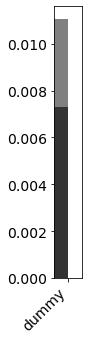

In [23]:
fig, ax = subplots(figsize=(len(trainingscores)/2, 5))

methodorder = testscores.sort_values(ascending=False).index

ax.bar(range(len(methodorder)), trainingscores[methodorder], color="grey")
ax.bar(range(len(methodorder)), testscores[methodorder], color="#333333")
ax.set_xlim(-0.2, len(methodorder))
ax.set_xticks(np.arange(len(methodorder))+0.4)
ax.set_xticklabels(methodorder, rotation=45, ha="right", va="top")
""


ax.tick_params(labelsize=14)